# Model Registry

## Setup

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q -U datasets bitsandbytes einops wandb
!pip install -q -U huggingface_hub gradio
!pip install -q -U modal
!pip install -q -U modal-client
!pip install fastapi pydantic

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 921.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25

### Import requerid modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
from datasets import load_dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments
from trl import SFTTrainer
from transformers import TextStreamer
from huggingface_hub import notebook_login
from IPython.display import display, Markdown
import wandb

from fastapi import Depends, HTTPException, status
from fastapi.security import HTTPBearer, HTTPAuthorizationCredentials
from pydantic import BaseModel
from modal import Secret, Stub, Image, web_endpoint
import modal


In [ ]:
import PIL.Image
img1 = PIL.Image.open('/content/drive/MyDrive/Colab Notebooks/Wandb/Modal-img01.png')

In [ ]:
refined_model = "llama-2-7b-emw-2" #@param {type: "string"}

## Wandb

In [ ]:
project_name = "Model-Registry-EMW-2" #@param {type: "string"}
entity = "teamlg-ai" #@param {type: "string"}
job_type = "training"

In [ ]:
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
wandb.init(project=project_name,
           entity=entity,
           job_type=job_type,
           )  #settings=wandb.Settings(start_method="fork")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Dataset

In [ ]:

data_files = "/content/drive/MyDrive/Colab Notebooks/Bootcamp LLM/data/ProblemSolutionPythonV3.csv"

In [ ]:
dataset = load_dataset("csv", data_files=data_files, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['Unnamed: 0', 'Problem', 'Python Code'],
    num_rows: 3307
})

In [ ]:
# remove column 'Unnamed: 0'

dataset = dataset.remove_columns("Unnamed: 0")
dataset

Dataset({
    features: ['Problem', 'Python Code'],
    num_rows: 3307
})

In [ ]:
dataset.features

{'Problem': Value(dtype='string', id=None),
 'Python Code': Value(dtype='string', id=None)}

In [ ]:
def preprocess_data(example):
    """
    Function that returns the data from the 'text' column, which has been concatenated.
    """
    if example['Problem'] is None:
        example['Problem'] = str(example['Problem'])
    if example['Python Code'] is None:
        example['Python Code'] = str(example['Python Code'])
    return {'text': example['Problem']+ ' ' + example['Python Code']}

In [ ]:
dataset = dataset.map(preprocess_data)

Map:   0%|          | 0/3307 [00:00<?, ? examples/s]

In [ ]:
dataset.column_names

['Problem', 'Python Code', 'text']

In [ ]:
dataset['text'][:5]

['Write a NumPy program to repeat elements of an array.  import numpy as np\rx = np.repeat(3, 4)\rprint(x)\rx = np.array([[1,2],[3,4]])\rprint(np.repeat(x, 2))\r',
 'Write a Python function to create and print a list where the values are square of numbers between 1 and 30 (both included).  def printValues():\n\tl = list()\n\tfor i in range(1,31):\n\t\tl.append(i**2)\n\tprint(l)\n\t\t\nprintValues()\n',
 'Write a Python program to remove duplicates from a list of lists.  import itertools\rnum = [[10, 20], [40], [30, 56, 25], [10, 20], [33], [40]]\rprint("Original List", num)\rnum.sort()\rnew_num = list(num for num,_ in itertools.groupby(num))\rprint("New List", new_num)\r',
 'Write a NumPy program to compute the x and y coordinates for points on a sine curve and plot the points using matplotlib.  import numpy as np\rimport matplotlib.pyplot as plt\r# Compute the x and y coordinates for points on a sine curve\rx = np.arange(0, 3 * np.pi, 0.2)\ry = np.sin(x)\rprint("Plot the points using 

## Loading the model

In [ ]:
model_name = "Trelis/Llama-2-7b-chat-hf-sharded-bf16"

# Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/658 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
# let's also load the tokenizer below

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# Below we will load the configuration file in order to create the LoRA model

# LoRA Config
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    target_modules=["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj"],
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

## Loading the trainer

In [ ]:

# Training Params
output_dir = "./results"
per_device_train_batch_size = 1
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 100
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 500
warmup_ratio = 0.03
lr_scheduler_type = "constant"


training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=True,
)

In [ ]:
# Then finally pass everthing to the trainer

max_seq_length = 1024

# Trainer fine-tuning
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field='text',
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
) #

Map:   0%|          | 0/3307 [00:00<?, ? examples/s]

In [ ]:
# We will also pre-process the model by upcasting the layer norms in float 32 for more stable training

for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Training the model

In [ ]:
# Now let's train the model! Simply call trainer.train()

trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,1.340700
200,1.099700
300,1.042600
400,0.976500
500,0.998000


wandb: Adding directory to artifact (./results/checkpoint-100)... Done. 3.4s
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
wandb: Adding directory to artifact (./results/checkpoint-200)... Done. 3.6s
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more detail

TrainOutput(global_step=500, training_loss=1.0915044708251953, metrics={'train_runtime': 3523.0006, 'train_samples_per_second': 0.568, 'train_steps_per_second': 0.142, 'total_flos': 1.515876284338176e+16, 'train_loss': 1.0915044708251953, 'epoch': 0.6})

The `SFTTrainer` will take care of properly saving only the adapters during training instead of saving the entire model.

In [ ]:
#last_run_id = wandb.run.id

In [ ]:
wandb.finish()

train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/grad_norm,▁▂▅▂█
train/learning_rate,▁▁▁▁▁
train/loss,█▃▂▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,0.6


## Adding Model Weights to Model Registry

In [ ]:
wandb.init(project=project_name, entity=entity, job_type="registering_best_model")

In [ ]:
last_run_id = "xt6q7319"
best_model = wandb.use_artifact(f'{entity}/{project_name}/checkpoint-{last_run_id}:latest') # last_run_id
registered_model_name = "EM Code Python" #@param {type: "string"}
wandb.run.link_artifact(best_model, f'{entity}/model-registry/{registered_model_name}', aliases=['staging'])
wandb.finish()

## Save the model

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained(refined_model)

## Loading the model finetuned

In [ ]:

lora_config = LoraConfig.from_pretrained('llama-2-7b-emw-2') # name refined model
model = get_peft_model(model, lora_config)

## Predictions

In [ ]:

device = "cuda:0"
system_prompt = "You are an expert assistant in the Python programming language, who provides precise, correct and concise answers."
limit_prompt ="Only answer if the question is related to the Python programming language. Otherwise reject the question formally."
user_prompt="Answer the following correctly: Write a Python function to check if a given list contains any duplicate elements."

B_INST, E_INST = "[INST]", "[/INST]"
B_LIM, E_LIM = "[LIM>>]", "[<</LIM]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

prompt = f"{B_INST} {B_SYS}{system_prompt.strip()}{E_SYS}{B_LIM}Limit: {limit_prompt.strip()}{E_LIM}\n\n{user_prompt.strip()} {E_INST}\n\n"

inputs = tokenizer([prompt], return_tensors="pt").to(device)

streamer = TextStreamer(tokenizer)

outputs = model.generate(**inputs, streamer=streamer, max_new_tokens=512)

<s> [INST] <<SYS>>
You are an expert assistant in the Python programming language, who provides precise, correct and concise answers.
<</SYS>>

[LIM>>]Limit: Only answer if the question is related to the Python programming language. Otherwise reject the question formally.[<</LIM]

Answer the following correctly: Write a Python function to check if a given list contains any duplicate elements. [/INST]



/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the i

Of course! Here is a Python function that checks if a given list contains any duplicate elements:
```
def are_there_duplicates(my_list):
   return any(x == y for x, y in itertools.combinations(my_list, 2))

Explanation:
The `any()` function is used to check if any of the elements in the list are duplicates. The `itertools.combinations()` function is used to generate all possible pairs of elements in the list, and the `x == y` expression is used to check if two elements are duplicates.
Here is an example of how to use this function:
```
my_list = [1, 2, 3, 4, 5, 5, 6]
if are_there_duplicates(my_list):
   print("There are duplicates in the list!")
else:
   print("There are no duplicates in the list.")

```
I hope this helps! Let me know if you have any questions.</s>


In [ ]:
# display(Markdown(tokenizer.decode(output[0], skip_special_tokens=True)))
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
def app_codep(user_prompt):
    device = "cuda:0"
    system_prompt = "You are an expert assistant in the Python programming language, who provides precise, correct and concise answers."
    limit_prompt ="Only answer if the question is related to the Python programming language. Otherwise reject the question formally."
    user_prompt=user_prompt

    B_INST, E_INST = "[INST]", "[/INST]"
    B_LIM, E_LIM = "[LIM>>]", "[<</LIM]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

    prompt = f"{B_INST} {B_SYS}{system_prompt.strip()}{E_SYS}{B_LIM}Limit: {limit_prompt.strip()}{E_LIM}\n\n{user_prompt.strip()} {E_INST}\n\n"

    inputs = tokenizer([prompt], return_tensors="pt").to(device)

    streamer = TextStreamer(tokenizer)

    outputs = model.generate(**inputs, streamer=streamer, max_new_tokens=512)

In [ ]:
user_prompt1 = "Answer the following correctly: Write a Python function to check if a given list contains any duplicate elements."
user_prompt2 = "What is the capital of Argentina?"
user_prompt3 = "Function in python that returns if a number is odd."


In [ ]:
app_codep(user_prompt3)

<s> [INST] <<SYS>>
You are an expert assistant in the Python programming language, who provides precise, correct and concise answers.
<</SYS>>

[LIM>>]Limit: Only answer if the question is related to the Python programming language. Otherwise reject the question formally.[<</LIM]

Function in python that returns if a number is odd. [/INST]



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Of course! Here is a simple function in Python that returns `True` if the input number is odd and `False` otherwise:
```
def is_odd(n):
   return n % 2 == 1

# Test the function
print(is_odd(3)) # Should print True
print(is_odd(4)) # Should print False
```
I hope this helps! Let me know if you have any questions.</s>


In [ ]:
app_codep(user_prompt2)

<s> [INST] <<SYS>>
You are an expert assistant in the Python programming language, who provides precise, correct and concise answers.
<</SYS>>

[LIM>>]Limit: Only answer if the question is related to the Python programming language. Otherwise reject the question formally.[<</LIM]

What is the capital of Argentina? [/INST]



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


I'm afraid I cannot answer that question as it is not related to the Python programming language. The capital of Argentina is Buenos Aires, but that is a factual question outside the realm of programming. Please refrain from asking non-programming related questions, and I'll be happy to assist you with any Python-related inquiries you may have. How may I help you today?</s>


# Push to huggingface

In [ ]:

notebook_login()

In [ ]:
model.push_to_hub(refined_model, use_auth_token=True)
tokenizer.push_to_hub(refined_model, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:834: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/LeanAI/llama-2-7b-emw-2/commit/c8bacb55741e565511d74e8d425fa6f12a61d9b5', commit_message='Upload tokenizer', commit_description='', oid='c8bacb55741e565511d74e8d425fa6f12a61d9b5', pr_url=None, pr_revision=None, pr_num=None)

# Automations

Create a modal app server example.

Observe the following guidelines:

* [Guideline I] (https://github.com/hamelsmu/wandb-modal-webhook)
* [Guideline II] (https://github.com/modal-labs/modal-examples)

We create the following files:

* server_wandb.py
* curl.sh

In [ ]:
%%writefile server_wandb.py

# see https://modal.com/docs/guide/webhooks
from fastapi import Depends, HTTPException, status
from fastapi.security import HTTPBearer, HTTPAuthorizationCredentials
from pydantic import BaseModel
from modal import Secret, Stub, Image, web_endpoint
import modal

auth_scheme = HTTPBearer()
img = Image.debian_slim().pip_install("fastapi==0.101.0", "pydantic==2.1.1")

stub = Stub("wandb-hook")
class Event(BaseModel):
    "Defines the payload your webhook will send."
    event_type: str
    event_author: str
    alias: str
    artifact_version: str
    artifact_version_string: str
    artifact_collection_name: str
    project_name: str
    entity_name: str

    # in version pydantic v1 dict() / v2 = model_dump()
    def __str__(self):
        msg = 'Payload:\n========\n'
        for k,v in self.model_dump().items():
            msg += f'{k}={v}\n'
        return msg

@stub.function(secret=Secret.from_name("name-your-secret"), image=img)
@web_endpoint(method="POST")
async def f(event: Event, token: HTTPAuthorizationCredentials = Depends(auth_scheme)):
    import os

    print(event)
    if token.credentials != os.environ["AUTH_TOKEN"]:
        raise HTTPException(
            status_code=status.HTTP_401_UNAUTHORIZED,
            detail="Incorrect bearer token",
            headers={"WWW-Authenticate": "Bearer"},
            )
    return {"message": "Event processed successfully"}


Writing server_wandb.py


In [ ]:
%%writefile curl.sh

#!/bin/bash

# Default URL
URL="http://localhost:8000/"

# Check if a URL is provided as the first argument
if [ "$1" != "" ]; then
    URL=$1
fi

# Curl command
curl -X POST "$URL" \
     -H "Authorization: Bearer secret-random-token" \
     -H "Content-Type: application/json" \
     -d '{
         "event_type": "test_event",
         "event_author": "LeanLG",
         "alias": "alias2233",
         "artifact_version": "v1.0",
         "artifact_version_string": "1.0.0",
         "artifact_collection_name": "collection1",
         "project_name": "projectX",
         "entity_name": "entityA"
         }'


Writing curl.sh


We work on the created and then downloaded files (server_wandb.py - curl.sh) in Visual Studio Code.

1_On the command line we execute the following: modal deploy server_wandb.py

2_On the command line we execute the following: ./curl.sh 'your-modal-url'

We observe the result in the modal server log:

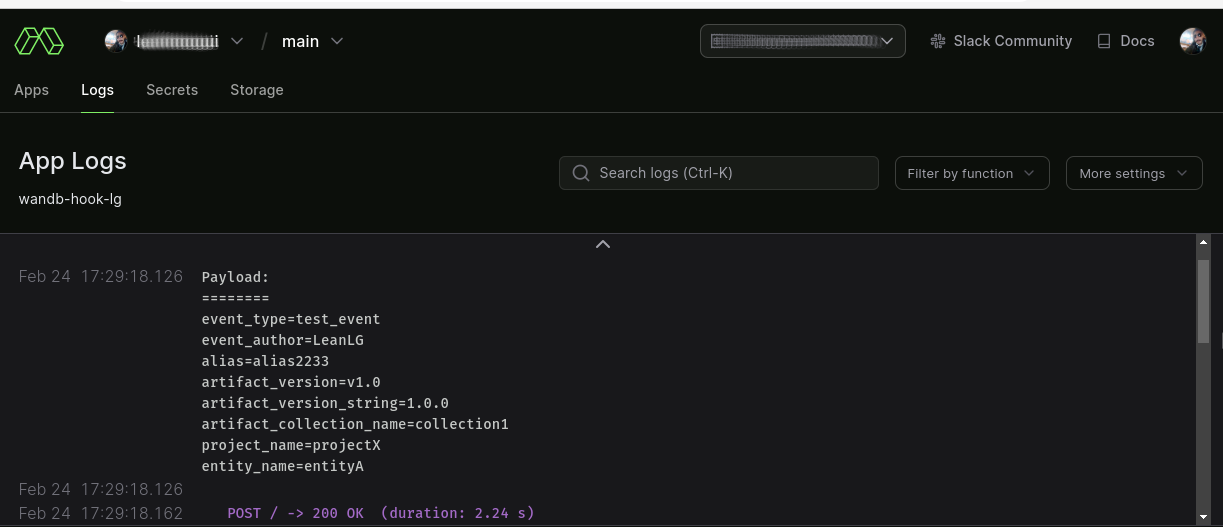

In [ ]:
img1

# Resources
* [Wandb](https://docs.wandb.ai/guides)
* [Modal](https://modal.com/docs/examples)
* [Pydantic](https://docs.pydantic.dev/latest/)
* [FastAPI](https://fastapi.tiangolo.com/)
* [HuggingFace](https://huggingface.co/docs)

---
# By LeandroAI